<a href="https://colab.research.google.com/github/msamir-dls/PEFT_LoRA_QLoRA/blob/main/Compare_LoRA_PEFT_ranks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets einops wandb bitsandbytes matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 145.1 MB/s eta 0:00:00


In [9]:
!pip uninstall -y flash-attn
!pip install -q ninja packaging
!pip install -q flash-attn --no-build-isolation

  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
import os
import time
import torch
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, field
from typing import List
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer, SFTConfig

In [2]:
@dataclass
class ExperimentConfig:
    model_name: str = "meta-llama/Meta-Llama-3-8B-Instruct"
    dataset_name: str = "timdettmers/openassistant-guanaco"
    output_base_dir: str = "./lora_experiments"
    ranks_to_test: List[int] = field(default_factory=lambda: [4, 8, 16, 32, 64])

    # Stability Parameters
    learning_rate: float = 1e-4
    batch_size: int = 1
    grad_accum_steps: int = 4
    num_epochs: int = 1
    max_seq_length: int = 512

    # Evaluation
    eval_samples: int = 100

config = ExperimentConfig()
set_seed(42)

In [3]:
def clear_gpu():
    """Aggressively clears GPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

In [4]:
def calculate_perplexity(model, tokenizer, dataset, max_samples=100):
    """
    Calculates perplexity on a specific dataset slice.
    Lower PPL = Better understanding.
    """
    model.eval()
    nlls = []

    # Use a small subset for speed
    subset = dataset.select(range(min(len(dataset), max_samples)))

    print(f"   -> Calculating Perplexity on {len(subset)} validation samples...")

    for example in subset:
        inputs = tokenizer(example["text"], return_tensors="pt", truncation=True, max_length=config.max_seq_length).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

In [17]:
class LoRAExperimentRunner:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.results = []
        self.loss_curves = {}
        self.tokenizer = self._load_tokenizer()

    def _load_tokenizer(self):
        tokenizer = AutoTokenizer.from_pretrained(self.config.model_name, trust_remote_code=True)
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = "right" # Llama 3 usually prefers right padding for training
        return tokenizer

    def _get_base_model(self):
        # Re-load base model for every rank to ensure clean state
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            attn_implementation="sdpa"
        )
        model = prepare_model_for_kbit_training(model)
        model.config.use_cache = False # Silence warnings
        return model

    def run_experiment(self, rank):
        alpha = rank * 2
        run_name = f"lora_r{rank}_alpha{alpha}"
        output_dir = os.path.join(self.config.output_base_dir, run_name)

        print(f"\n{'='*60}")
        print(f"🚀 Starting Experiment: Rank={rank}, Alpha={alpha}")
        print(f"{'='*60}")

        # 1. Load Model
        clear_gpu()
        model = self._get_base_model()

        # 2. Configure LoRA
        peft_config = LoraConfig(
            r=rank,
            lora_alpha=alpha,
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM",
            target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
        )

        # 3. Prepare Dataset
        dataset = load_dataset(self.config.dataset_name, split="train")

        # 4. Initialize Trainer
        training_args = SFTConfig(
            output_dir=output_dir,
            num_train_epochs=self.config.num_epochs,
            per_device_train_batch_size=self.config.batch_size,
            gradient_accumulation_steps=self.config.grad_accum_steps,
            learning_rate=self.config.learning_rate,
            logging_steps=10,
            save_strategy="no",
            fp16=False,
            bf16=True,
            optim="paged_adamw_8bit",
            max_grad_norm=0.3,
            warmup_ratio=0.03,
            lr_scheduler_type="cosine",
            report_to="none",
            dataset_text_field="text",
            # max_seq_length=self.config.max_seq_length
        )

        # FIX IS HERE: processing_class instead of tokenizer
        trainer = SFTTrainer(
            model=model,
            train_dataset=dataset,
            peft_config=peft_config,
            processing_class=self.tokenizer,
            args=training_args
        )

        # Fix norm layers for float32 stability
        for name, module in trainer.model.named_modules():
             if "norm" in name:
                 module.to(torch.float32)

        # 5. Measure Resources (Before)
        torch.cuda.reset_peak_memory_stats()
        start_time = time.time()

        # 6. TRAIN
        train_result = trainer.train()

        # 7. Measure Resources (After)
        training_time = time.time() - start_time
        peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) # GB

        # 8. Extract Loss Curve
        history = pd.DataFrame(trainer.state.log_history)
        if 'loss' in history.columns:
            clean_history = history.dropna(subset=['loss'])
            self.loss_curves[rank] = clean_history[['step', 'loss']]

        # 9. Evaluate Perplexity
        # (Pass the base model + adapter for inference)
        ppl_score = calculate_perplexity(trainer.model, self.tokenizer, dataset, max_samples=self.config.eval_samples)

        # 10. Save Checkpoint
        trainer.model.save_pretrained(output_dir)

        print(f"✅ Finished r={rank}. Time: {training_time:.1f}s, Mem: {peak_memory:.2f}GB, PPL: {ppl_score:.2f}")

        # Record Results
        self.results.append({
            "Rank": rank,
            "Alpha": alpha,
            "Training Time (s)": round(training_time, 2),
            "Peak Memory (GB)": round(peak_memory, 2),
            "Perplexity": round(ppl_score, 4),
            "Final Loss": round(clean_history['loss'].iloc[-1], 4) if not clean_history.empty else 0
        })

        # Cleanup
        del model
        del trainer
        clear_gpu()


    def compare_results(self):
        # Dataframe
        df = pd.DataFrame(self.results)
        print("\n\n🏆 --- FINAL COMPARISON REPORT ---")
        print(df.to_markdown(index=False))

        # Plotting Loss Curves
        plt.figure(figsize=(12, 8))
        for rank, data in self.loss_curves.items():
            plt.plot(data['step'], data['loss'], label=f"Rank {rank} (α={rank*2})")

        plt.title("Loss Curve Comparison by LoRA Rank")
        plt.xlabel("Steps")
        plt.ylabel("Training Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [6]:
from huggingface_hub import notebook_login
notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🚀 Starting Experiment: Rank=4, Alpha=8


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Adding EOS to train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Step,Training Loss
10,1.755919
20,1.641307
30,1.675768
40,1.442198
50,1.625177
60,1.271659
70,1.351397
80,1.437050
90,1.319628
100,1.350056


   -> Calculating Perplexity on 100 validation samples...
✅ Finished r=4. Time: 7458.5s, Mem: 17.58GB, PPL: 4.09

🚀 Starting Experiment: Rank=8, Alpha=16


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Tokenizing train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Step,Training Loss
10,1.754187
20,1.626801
30,1.613516
40,1.405107
50,1.597271
60,1.253723
70,1.326398
80,1.418742
90,1.314488
100,1.348147


   -> Calculating Perplexity on 100 validation samples...
✅ Finished r=8. Time: 7498.0s, Mem: 19.57GB, PPL: 3.99

🚀 Starting Experiment: Rank=16, Alpha=32


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Step,Training Loss
10,1.750526
20,1.597446
30,1.539104
40,1.380323
50,1.575332
60,1.233790
70,1.315774
80,1.414320
90,1.311694
100,1.346657


   -> Calculating Perplexity on 100 validation samples...
✅ Finished r=16. Time: 7472.3s, Mem: 21.63GB, PPL: 3.84

🚀 Starting Experiment: Rank=32, Alpha=64


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Step,Training Loss
10,1.743167
20,1.550363
30,1.487999
40,1.353800
50,1.551164
60,1.224278
70,1.313299
80,1.408800
90,1.308529
100,1.347377


   -> Calculating Perplexity on 100 validation samples...
✅ Finished r=32. Time: 7454.5s, Mem: 23.71GB, PPL: 3.61

🚀 Starting Experiment: Rank=64, Alpha=128


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Step,Training Loss
10,1.730269
20,1.492497
30,1.456129
40,1.328236
50,1.544854
60,1.220070
70,1.310523
80,1.406852
90,1.309026
100,1.349415


   -> Calculating Perplexity on 100 validation samples...
✅ Finished r=64. Time: 7496.0s, Mem: 26.04GB, PPL: 3.33


🏆 --- FINAL COMPARISON REPORT ---
|   Rank |   Alpha |   Training Time (s) |   Peak Memory (GB) |   Perplexity |   Final Loss |
|-------:|--------:|--------------------:|-------------------:|-------------:|-------------:|
|      4 |       8 |             7458.5  |              17.58 |       4.0933 |       1.2847 |
|      8 |      16 |             7497.99 |              19.57 |       3.9903 |       1.2796 |
|     16 |      32 |             7472.32 |              21.63 |       3.8357 |       1.2765 |
|     32 |      64 |             7454.47 |              23.71 |       3.6129 |       1.2756 |
|     64 |     128 |             7496.04 |              26.04 |       3.3334 |       1.2781 |


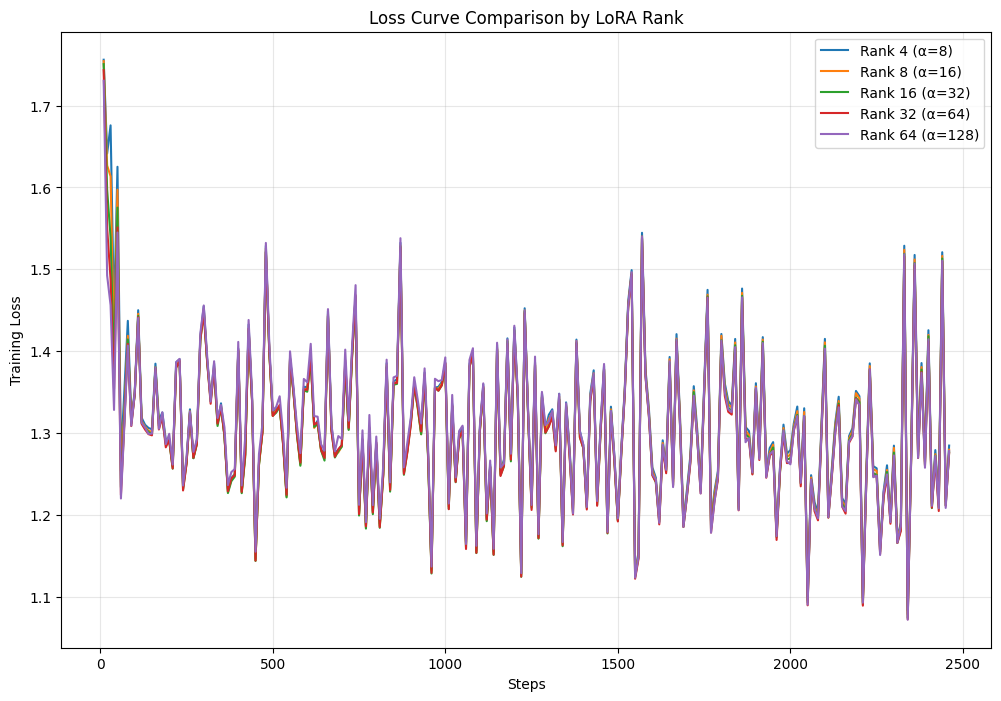

In [18]:
runner = LoRAExperimentRunner(config)

for r in config.ranks_to_test:
    runner.run_experiment(r)

runner.compare_results()